### Step 1: Retrieve homologs of known Proton pumping microbial rhodopsins



| Gene name                        | Species                                              | λmax (nm) | GenBank protein accession | Source reference                                 |
|-----------------------------------|-----------------------------------------------------|-----------|--------------------------|--------------------------------------------------|
| Y_CyRII_P7104R                   | Nodosilinea nodulosa PCC 7104                       | 570       | WP_017301364.1           | Hasegawa-Takano et al. 2024 (ISME J)             |
| BR (Bacteriorhodopsin)           | Halobacterium salinarum                             | 570       | WP_136361479.1           | Oesterhelt & Stoeckenius 1971; Lozier et al. 1975|
| N2098R                           | Calothrix sp. NIES-2098                             | 550       | BAY09002.1               | Hasegawa et al. 2020 (Sci Rep)                   |
| GR (Gloeobacter rhodopsin)       | Gloeobacter violaceus PCC 7421                      | 544       | WP_011140202.1           | Choi et al. 2014 (PLoS ONE)                      |
| PR (GPR, green proteorhodopsin)  | Uncultivated marine γ-proteobacterium (SAR86; EBAC31A08) | 520   | AAG10475.1               | Béjà et al. 2000 (Science)                       |
| PR (BPR, blue proteorhodopsin)   | Marine bacterioplankton (HOT75m4 variant)           | 490       | Q9AFF7.2                 | Béjà et al. 2001 (Nature)                        |


Create a table from data above from Hasegawa-Takano et al 2024. Find similar sequences to those, totaling 90 sequences.

In [1]:
from pathlib import Path

#Define paths for current project
# --- Centralized paths ---
ROOT = Path("..")
DATA = ROOT / "data"
LOGS = ROOT / "logs"
SCRIPTS = ROOT / "scripts"
RESULTS = ROOT / "results"
ALIGN_DIR = RESULTS / "align"
TREE_DIR = RESULTS / "trees"
FIGURES = RESULTS / "figures"


In [2]:
#Using table above as bait, search Uniref and download clost blast hits of Uniref90

#This takes about 50 minutes for a run from scratch

#job_id = "ncbiblast-I20250901-173114-0788-19601246-p1m"
#!python {SCRIPTS / "blast_uniref90.py"} dummy dummy --max_hits 33 --out {DATA / "WP_011140202.1_top33_uniref90.fasta"} --log {LOGS / "WP_011140202.1_blast_runs.log"} --jobid {job_id} --force

from pathlib import Path

# Table of accessions and max_hits. Aiming for 15,15,15,15,30 .. but need to add a few to account for
# later deletions of incomplete sequences

bait_table = [
    ("YCyR2hit", "WP_017301364.1", 15),
    ("BRhit", "WP_136361479.1", 16),
    ("GCyR2hit", "BAY09002.1", 18),
    ("GRhit", "WP_011140202.1", 32),
    #("GPRhit", "AAG10475.1", 10),
    #("BPRhit", "Q9AFF7.2", 10), #BPR and GPR mostly hitting the same genes, just do PR instead
    ("PRhit", "AAG10475.1", 15),
]

#run_table = [
#    ("BRhit", "WP_136361479.1", "ncbiblast-R20250902-012715-0963-64586178-p1m", 17),
#    ("GRhit", "WP_011140202.1", "ncbiblast-R20250902-014018-0359-36391454-p1m", 32),
#    ("GCyR2hit", "BAY09002.1", "ncbiblast-R20250902-013359-0049-40227659-p1m", 18),
#]

email = "oakley@ucsb.edu"

#for prefix, accession, job_id, max_hits in run_table:
#    out_fasta = DATA / f"{accession}_top{max_hits}_uniref90.fasta"
#    log_file = LOGS / f"{accession}_blast_runs.log"
#    print(f"Fetching BLAST results for {prefix} (job_id={job_id}, max_hits={max_hits})")
#    !python {SCRIPTS / "blast_uniref90.py"} --max_hits {max_hits} --out {out_fasta} --log {log_file} --jobid {job_id}

for prefix, accession, max_hits in bait_table:
    out_fasta = DATA / f"{accession}_top{max_hits}_uniref90.fasta"
    log_file = LOGS / f"{accession}_blast_runs.log"
    print(f"Running BLAST for {accession} (max_hits={max_hits})")
    !python {SCRIPTS / "blast_uniref90.py"} {accession} {email} --max_hits {max_hits} --out {out_fasta} --log {log_file}

Running BLAST for WP_017301364.1 (max_hits=15)
ERROR: Output file ../data/WP_017301364.1_top15_uniref90.fasta already exists. Use --force to overwrite.
ERROR:root:ERROR: Output file ../data/WP_017301364.1_top15_uniref90.fasta already exists. Use --force to overwrite.
Running BLAST for WP_136361479.1 (max_hits=16)
ERROR: Output file ../data/WP_136361479.1_top16_uniref90.fasta already exists. Use --force to overwrite.
ERROR:root:ERROR: Output file ../data/WP_136361479.1_top16_uniref90.fasta already exists. Use --force to overwrite.
Running BLAST for BAY09002.1 (max_hits=18)
ERROR: Output file ../data/BAY09002.1_top18_uniref90.fasta already exists. Use --force to overwrite.
ERROR:root:ERROR: Output file ../data/BAY09002.1_top18_uniref90.fasta already exists. Use --force to overwrite.
Running BLAST for WP_011140202.1 (max_hits=32)
ERROR: Output file ../data/WP_011140202.1_top32_uniref90.fasta already exists. Use --force to overwrite.
ERROR:root:ERROR: Output file ../data/WP_011140202.1_top

In [3]:
# Rename the sequences with a common prefix to keep track of them during analyses

#Need bait_table from above
renamed_files = []

for prefix, accession, max_hits in bait_table:
    blast_out = DATA / f"{accession}_top{max_hits}_uniref90.fasta"
    renamed_fasta = DATA / f"{accession}_top{max_hits}_renamed.fasta"
    renamed_files.append(renamed_fasta)
    print(f"Renaming {blast_out} -> {renamed_fasta} with prefix {prefix}")
    !python {SCRIPTS / "rename_fasta_headers.py"} {blast_out} {renamed_fasta} --prefix {prefix} --force

# Concatenate all renamed FASTA files into one
combined_fasta = DATA / "pumphits.fasta"
with open(combined_fasta, "w") as outfile:
    for fname in renamed_files:
        with open(fname) as infile:
            outfile.write(infile.read())
print(f"Combined all renamed FASTA files into {combined_fasta}")

Renaming ../data/WP_017301364.1_top15_uniref90.fasta -> ../data/WP_017301364.1_top15_renamed.fasta with prefix YCyR2hit
Reformatted 15 headers → ../data/WP_017301364.1_top15_renamed.fasta
Renaming ../data/WP_136361479.1_top16_uniref90.fasta -> ../data/WP_136361479.1_top16_renamed.fasta with prefix BRhit
Reformatted 15 headers → ../data/WP_136361479.1_top16_renamed.fasta
Renaming ../data/BAY09002.1_top18_uniref90.fasta -> ../data/BAY09002.1_top18_renamed.fasta with prefix GCyR2hit
Reformatted 16 headers → ../data/BAY09002.1_top18_renamed.fasta
Renaming ../data/WP_011140202.1_top32_uniref90.fasta -> ../data/WP_011140202.1_top32_renamed.fasta with prefix GRhit
Reformatted 32 headers → ../data/WP_011140202.1_top32_renamed.fasta
Renaming ../data/AAG10475.1_top15_uniref90.fasta -> ../data/AAG10475.1_top15_renamed.fasta with prefix PRhit
Reformatted 15 headers → ../data/AAG10475.1_top15_renamed.fasta
Combined all renamed FASTA files into ../data/pumphits.fasta


In [4]:
# A well known red-shifted BR is called D85A as far as I can tell, that doesn't occur in the 85th
# aa but rather at about 97. Changing that here. See for example Karayuma database for ML, the
# last sequence is this one

from Bio import Entrez, SeqIO, SeqRecord, Seq

Entrez.email = "oakley@ucsb.edu"
accession = "WP_136361479.1"

# Fetch sequence from GenBank
handle = Entrez.efetch(db="protein", id=accession, rettype="fasta", retmode="text")
record = SeqIO.read(handle, "fasta")
handle.close()

seq_list = list(str(record.seq))
motif = "YADWL"
motif_pos = str(record.seq).find(motif)
if motif_pos != -1:
    d_index = motif_pos + 2
    if seq_list[d_index] == "D":
        seq_list[d_index] = "A"
        print(f"Mutated D at position {d_index+1} (YADWL motif) to A.")
    else:
        print(f"Warning: Central residue of YADWL is not D, found {seq_list[d_index]}")
else:
    print("YADWL motif not found in sequence.")

mutated_seq = "".join(seq_list)
mutated_id = "BRmutant_" + accession + "_D85A"
mutated_record = SeqRecord.SeqRecord(Seq.Seq(mutated_seq), id=mutated_id, description="")

output_path = DATA / f"{mutated_id}.fasta"
with open(output_path, "w") as out_handle:
    SeqIO.write(mutated_record, out_handle, "fasta")
print(f"Mutated sequence written to {output_path}")

# Concatenate mutated sequence to pumphits.fasta and write to pumphitsM.fasta
pumphits_path = DATA / "pumphits.fasta"
mutant_path = DATA / "pumphitsM.fasta"

with open(mutant_path, "w") as out_handle:
    with open(pumphits_path) as in_handle:
        out_handle.write(in_handle.read())
    SeqIO.write(mutated_record, out_handle, "fasta")

print(f"Mutant FASTA written to {mutant_path}")

Mutated D at position 99 (YADWL motif) to A.
Mutated sequence written to ../data/BRmutant_WP_136361479.1_D85A.fasta
Mutant FASTA written to ../data/pumphitsM.fasta


In [5]:
#Delete some sequences that are partial

from pathlib import Path
from Bio import SeqIO

# Input FASTA to filter (update this as needed)
input_fasta = DATA / "pumphitsM.fasta"  # <-- This is your starting file
CULLED_FASTA = DATA / "pumphits_culled.fasta"  # Output after removing sequences

# List of sequence IDs to remove (exact matches) because they are truncated and probably incomplete
remove_ids = [
    "BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6",
    "GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169",
]

def normalize_id(s):
    # Remove quotes, whitespace, tabs, and collapse all spaces
    return "".join(s.strip().strip('"').strip("'").split())

remove_ids_normalized = set(normalize_id(x) for x in remove_ids)

# Remove listed sequences and write culled FASTA
records = []
removed_count = 0
with open(input_fasta) as in_handle:
    for record in SeqIO.parse(in_handle, "fasta"):
        rec_id_norm = normalize_id(record.id)
        if rec_id_norm not in remove_ids_normalized:
            records.append(record)
        else:
            print(f"Removed: {record.id!r} (normalized: {rec_id_norm!r})")
            removed_count += 1

with open(CULLED_FASTA, "w") as out_handle:
    SeqIO.write(records, out_handle, "fasta")

print(f"Filtered FASTA written to {CULLED_FASTA}")
print(f"Total sequences removed: {removed_count}")
print(f"Total unique sequences retained: {len(records)}")

# Align with MAFFT
ALN_FASTA = ALIGN_DIR / "pumphits_ALN.fasta"
!mafft --auto --thread -1 --quiet "{CULLED_FASTA}" > "{ALN_FASTA}"
print("Aligned ->", ALN_FASTA)

# Build a maximum likelihood tree with IQ-TREE2
IQ_PREFIX = TREE_DIR / "pumphits_iqtree"
#!iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet

Removed: 'BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77' (normalized: 'BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77')
Removed: 'GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9' (normalized: 'GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9')
Removed: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169' (normalized: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169')
Removed: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6' (normalized: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6')
Filtered FASTA written to ../data/pumphits_culled.fasta
Total sequences removed: 4
Total unique sequences retained: 90
Aligned -> ../results/align/pumphits_ALN.fasta


In [6]:
# Count the number of times each bait prefix appears in the aligned FASTA
# Just checking final numbers
from Bio import SeqIO

bait_prefixes = [x[0] for x in bait_table]
counts = {prefix: 0 for prefix in bait_prefixes}

with open(ALN_FASTA) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        for prefix in bait_prefixes:
            if record.id.startswith(prefix):
                counts[prefix] += 1

for prefix, count in counts.items():
    print(f"{prefix}: {count}")

YCyR2hit: 15
BRhit: 14
GCyR2hit: 15
GRhit: 30
PRhit: 15


Saved tree figure to: ../results/figures/pumphits_iqtree_tree.pdf


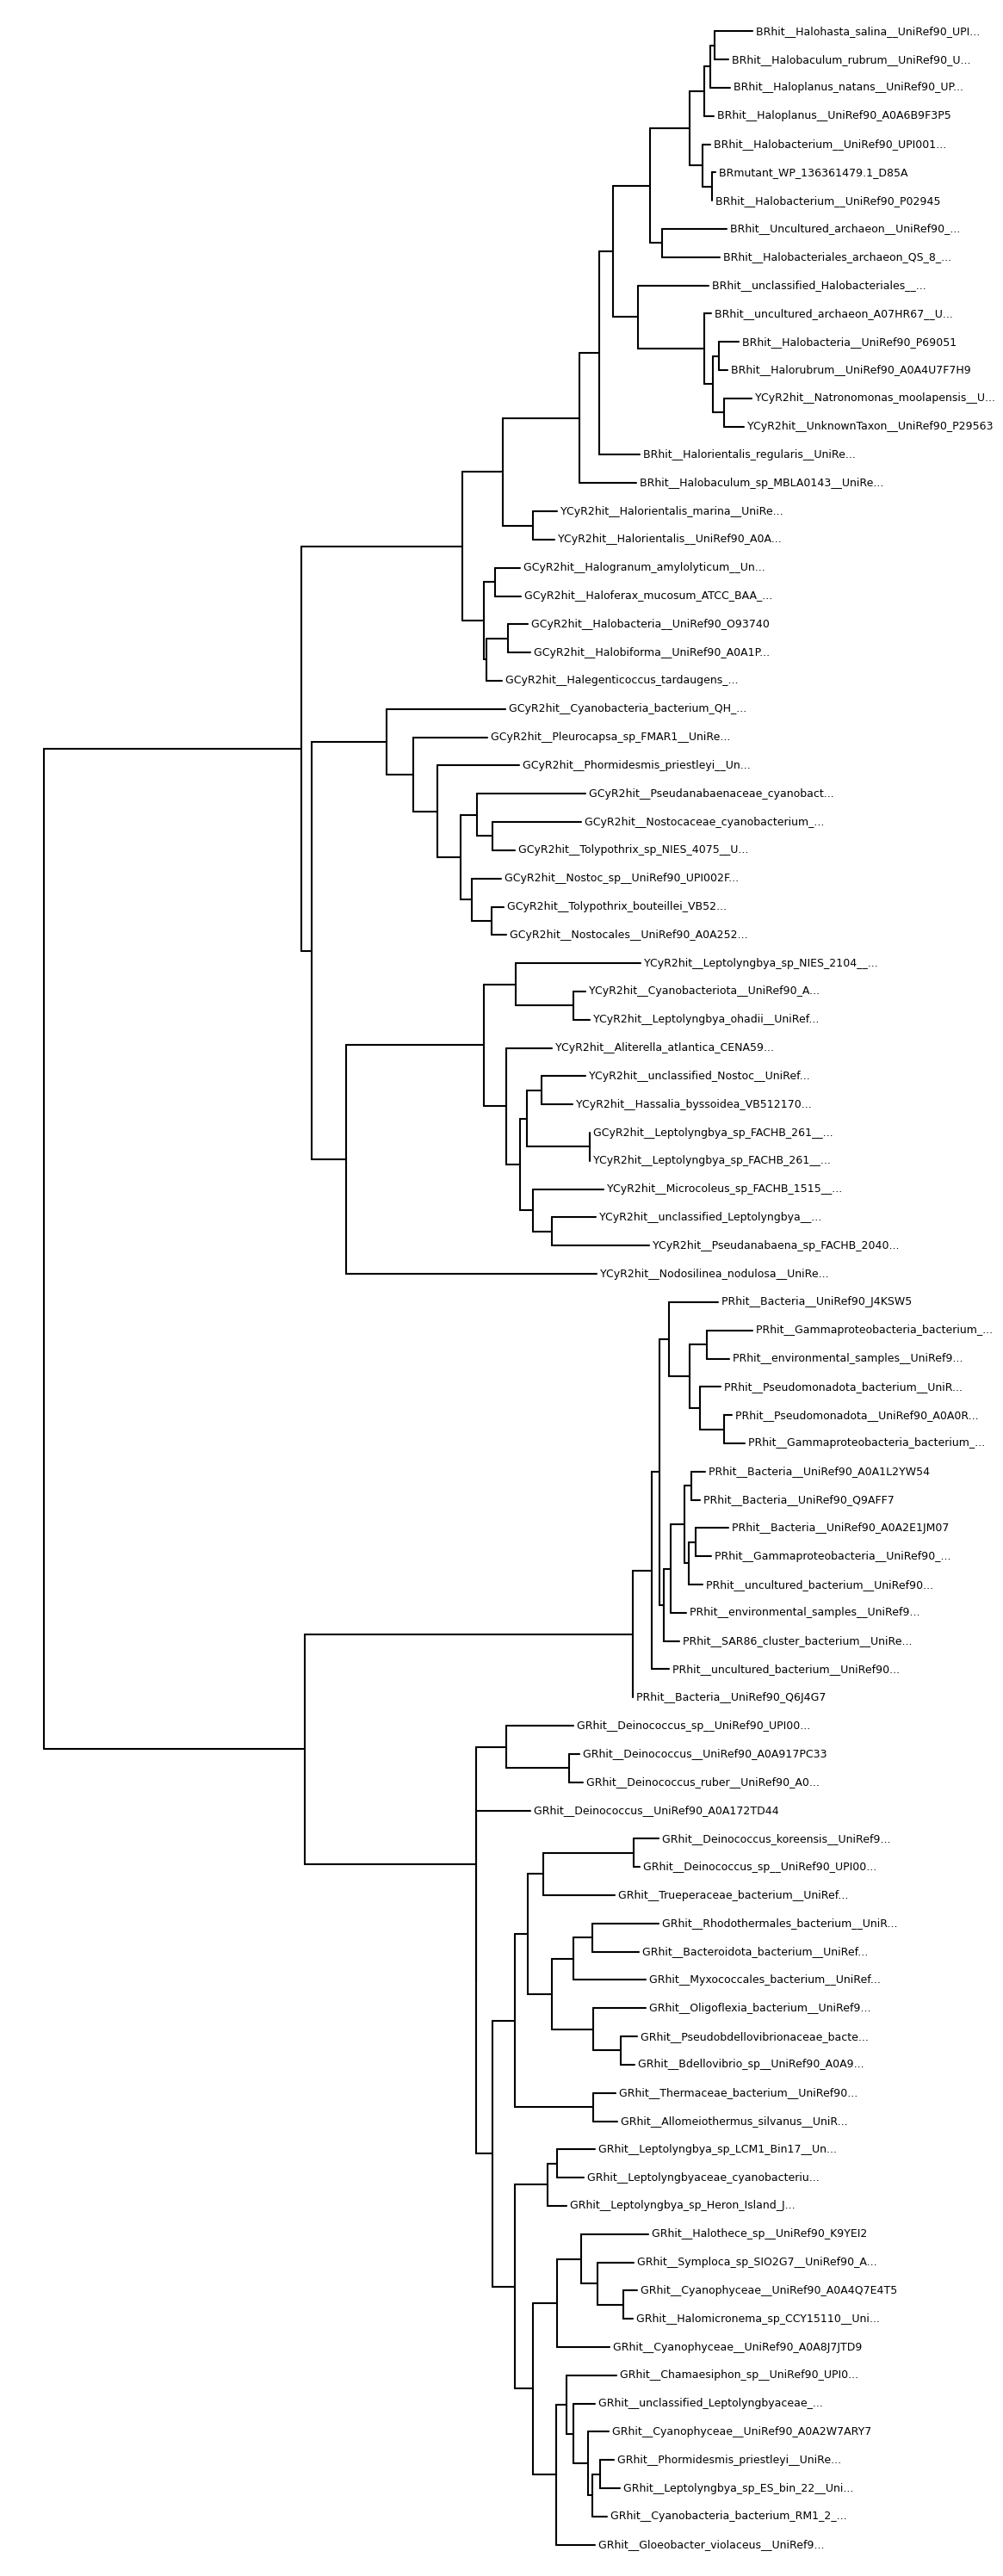

In [25]:

#Check the phylogeny for proton pump hits
import sys
sys.path.append(str(SCRIPTS))
from plot_tree import plot_tree

# Set IQ_PREFIX so output files go into TREE_DIR
IQ_PREFIX = TREE_DIR / "pumphits_iqtree"

# IQ-TREE2 command (in shell, use -pre "{IQ_PREFIX}" to ensure output goes to TREE_DIR)
!iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet -redo

# In Python, use IQ_PREFIX for downstream file paths
tree_file = IQ_PREFIX.with_suffix(".treefile")
fig_path = FIGURES / f"{IQ_PREFIX.name}_tree.pdf"

plot_tree(tree_file, save_path=fig_path, figsize=(12, 30))

### Step 2: Retrieve diverse microbial opsins from study by Hasegawa-Katano 24

In [27]:
import pandas as pd
from pathlib import Path
from Bio import Entrez

Entrez.email = "oakley@ucsb.edu"

csv_path = DATA / "hasegawa24" / "Supporting_Data_3.csv"
df = pd.read_csv(csv_path)
accession_col = "rhodopsin_accessions"  # Adjust if needed

output_fasta = DATA / "hasegawa24" / "rhodopsins_from_accessions.fasta"

def parse_accession(entry):
    entry = entry.strip().strip('"').strip("'")
    # Example: "BAC88139.1 (XLR)"
    if "(" in entry and ")" in entry:
        acc = entry.split("(")[0].strip()
        clade = entry.split("(")[1].split(")")[0].strip()
        return acc, clade
    else:
        return entry, ""

# Flatten and parse accessions
all_entries = (
    df[accession_col]
    .dropna()
    .apply(lambda x: [a.strip().strip('"').strip("'") for a in str(x).split(",")])
    .explode()
    .dropna()
)

parsed = [parse_accession(e) for e in all_entries if e]

with open(output_fasta, "w") as out_handle:
    for acc, clade in parsed:
        try:
            handle = Entrez.efetch(db="protein", id=acc, rettype="fasta", retmode="text")
            seq = handle.read()
            if seq.strip() and seq.startswith(">"):
                # Add clade to FASTA header with underscore instead of space
                lines = seq.splitlines()
                if clade and lines:
                    lines[0] = f">{clade}_{lines[0][1:]}"
                    seq = "\n".join(lines)
                out_handle.write(seq + "\n")
            else:
                print(f"Did not find {acc}")
        except Exception:
            print(f"Did not find {acc}")

print(f"Sequences written to {output_fasta}")

Did not find SRR6869043_N0001541_6
Did not find SRR6869043_N0010062_2
Did not find SRR6869040_N0001326_5
Did not find SRR6869040_N0001714_12
Sequences written to ../data/hasegawa24/rhodopsins_from_accessions.fasta


In [28]:
#Combine with proton pump hits from above and remove a few truncated sequences

from pathlib import Path
from Bio import SeqIO

# Define input files
fasta1 = DATA / "pumphits_culled.fasta"  # Output after removing sequences
fasta2 = DATA / "hasegawa24" / "rhodopsins_from_accessions.fasta"
combined_fasta = DATA / "combined_plus_hasegawa24.fasta"

# Combine the two FASTA files
with open(combined_fasta, "w") as outfile:
    for fname in [fasta1, fasta2]:
        with open(fname) as infile:
            outfile.write(infile.read())

print(f"Combined FASTA written to {combined_fasta}")

# File to filter
input_fasta = DATA / "combined_plus_hasegawa24.fasta"
output_fasta = DATA / "combined_plus_hasegawa24_culled.fasta"

# List of sequence IDs to remove (exact matches)
remove_ids = [
    "BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6",
    "GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169",
    "XeR_AFY92621.1",
    "CyR-II_MBV9385464.1",
    #Next is missing conserved lysine
    "XeR_ACL43260.1",    
]

def normalize_id(s):
    # Remove quotes, whitespace, tabs, and collapse all spaces
    return "".join(s.strip().strip('"').strip("'").split())

# Normalize remove_ids for robust matching
remove_ids_normalized = set(normalize_id(x) for x in remove_ids)

# Remove listed sequences and deduplicate by sequence
records = []
removed_count = 0
with open(input_fasta) as in_handle:
    for record in SeqIO.parse(in_handle, "fasta"):
        rec_id_norm = normalize_id(record.id)
        if rec_id_norm not in remove_ids_normalized:
            records.append(record)
        else:
            print(f"Removed: {record.id!r} (normalized: {rec_id_norm!r})")
            removed_count += 1

# Deduplicate by sequence (keep first occurrence)
seq_seen = set()
deduped_records = []
for rec in records:
    seq_str = str(rec.seq)
    if seq_str not in seq_seen:
        deduped_records.append(rec)
        seq_seen.add(seq_str)

with open(output_fasta, "w") as out_handle:
    SeqIO.write(deduped_records, out_handle, "fasta")

print(f"Filtered and deduplicated FASTA written to {output_fasta}")
print(f"Total sequences removed: {removed_count}")
print(f"Total unique sequences retained: {len(deduped_records)}")

# Align with MAFFT
ALN_FASTA = ALIGN_DIR / "combined_plus_hasegawa24_ALN.fasta"
!mafft --auto --thread -1 --quiet "{output_fasta}" > "{ALN_FASTA}"
print("Aligned ->", ALN_FASTA)

Combined FASTA written to ../data/combined_plus_hasegawa24.fasta
Removed: 'XeR_ACL43260.1' (normalized: 'XeR_ACL43260.1')
Removed: 'XeR_AFY92621.1' (normalized: 'XeR_AFY92621.1')
Removed: 'CyR-II_MBV9385464.1' (normalized: 'CyR-II_MBV9385464.1')
Filtered and deduplicated FASTA written to ../data/combined_plus_hasegawa24_culled.fasta
Total sequences removed: 3
Total unique sequences retained: 160
Aligned -> ../results/align/combined_plus_hasegawa24_ALN.fasta


Checkpoint (../results/trees/combined_plus_hasegawa24_iqtree.ckp.gz) indicates that a previous run successfully finished
Use `-redo` option if you really want to redo the analysis and overwrite all output files.
Use `--redo-tree` option if you want to restore ModelFinder and only redo tree search.
Use `--undo` option if you want to continue previous run when changing/adding options.
Saved tree figure to: ../results/figures/combined_plus_hasegawa24_iqtree_tree.pdf


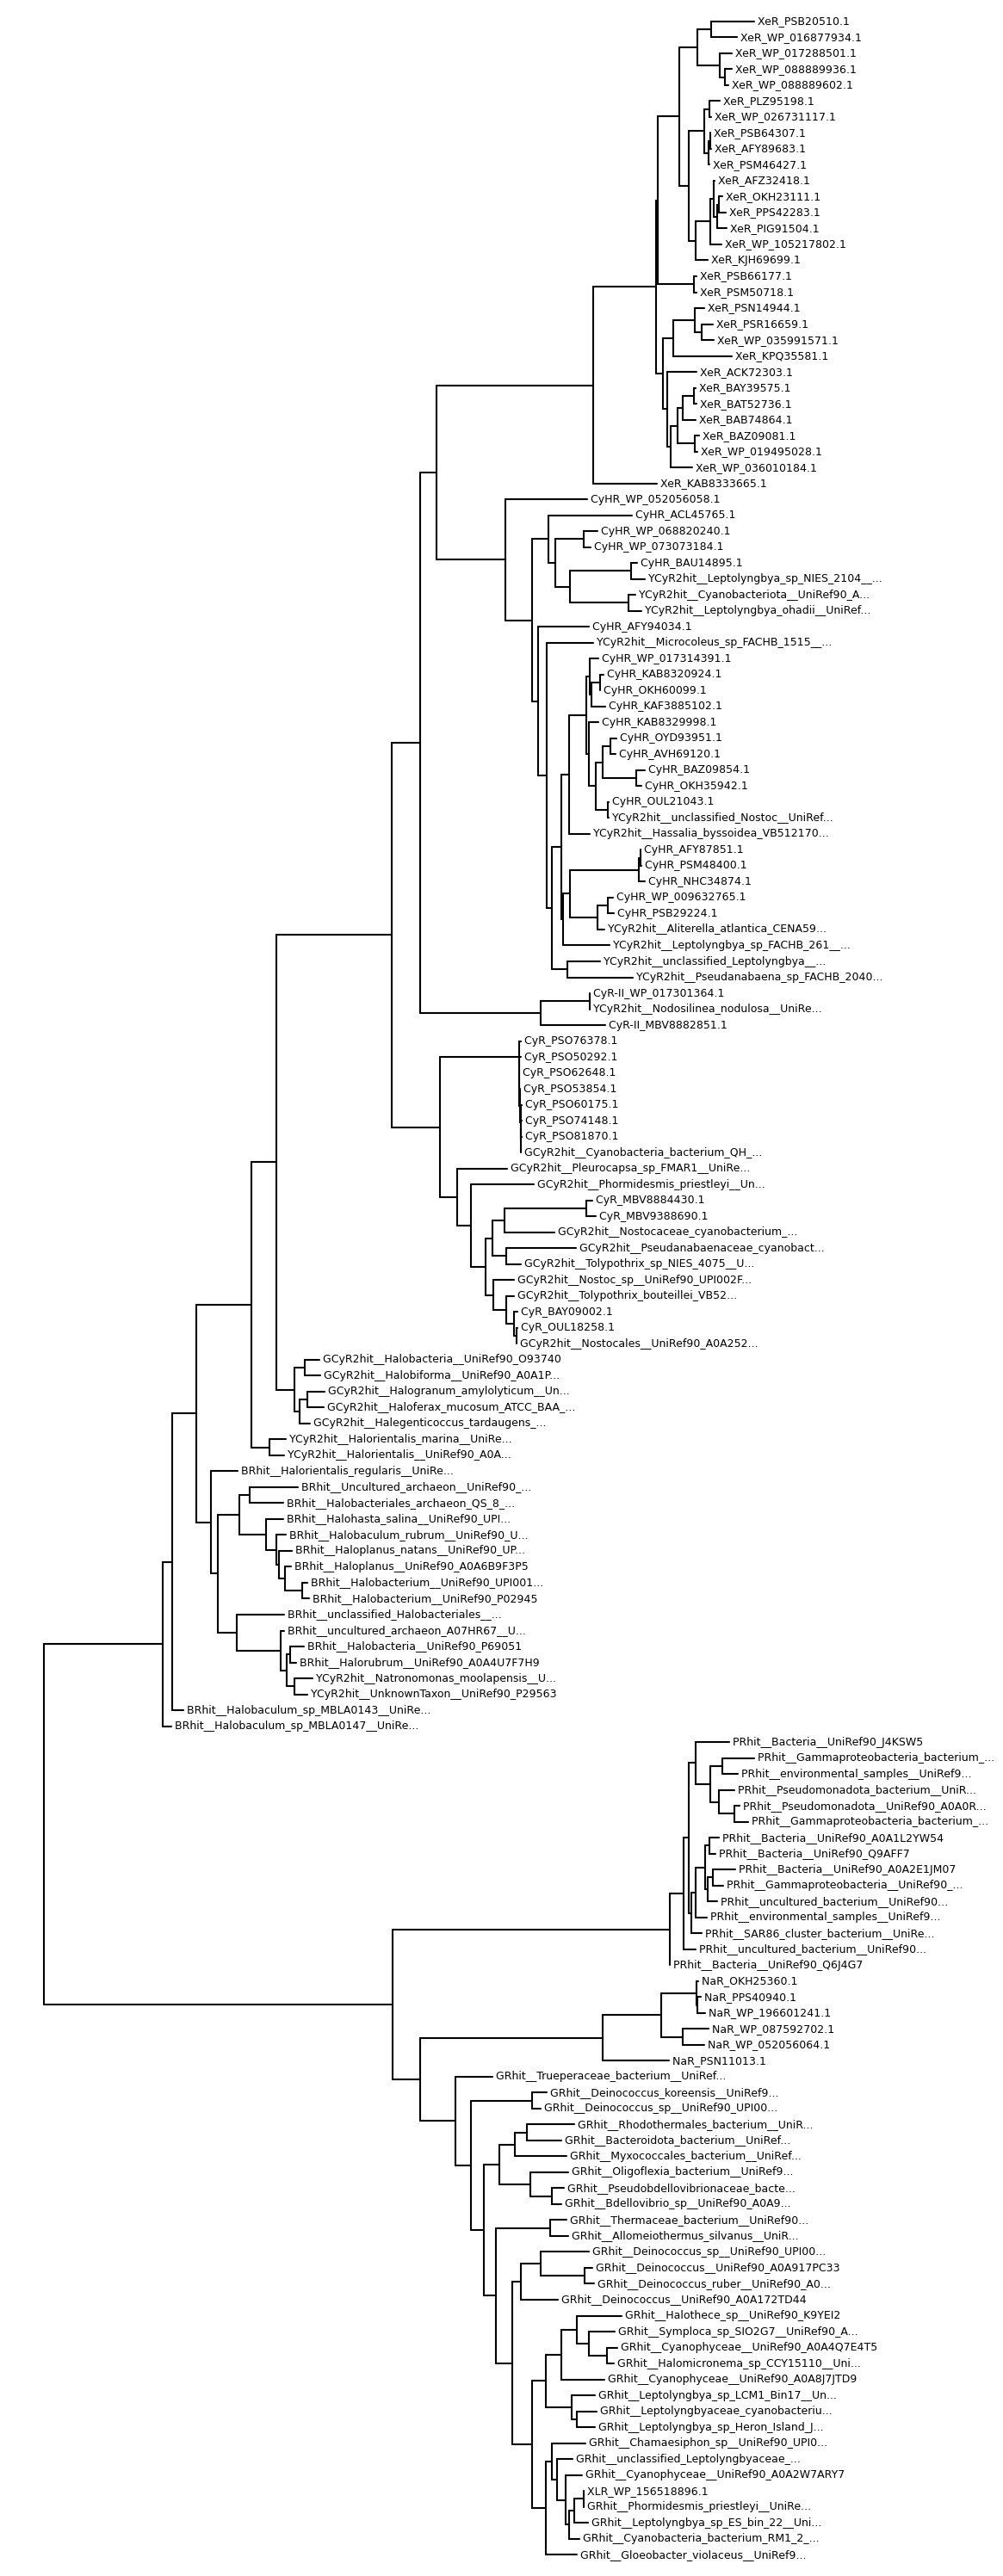

In [ ]:
#Check the phylogeny for proton pump hits
import sys
sys.path.append(str(SCRIPTS))
from plot_tree import plot_tree

# Set IQ_PREFIX so output files go into TREE_DIR
IQ_PREFIX = TREE_DIR / "combined_plus_hasegawa24_iqtree"

#mafft run in previous cell
ALN_FASTA = ALIGN_DIR / "combined_plus_hasegawa24_ALN.fasta"

# IQ-TREE2 command (in shell, use -pre "{IQ_PREFIX}" to ensure output goes to TREE_DIR)
!iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet

# In Python, use IQ_PREFIX for downstream file paths
tree_file = IQ_PREFIX.with_suffix(".treefile")
fig_path = FIGURES / f"{IQ_PREFIX.name}_tree.pdf"

plot_tree(tree_file, save_path=fig_path, figsize=(12, 30))